In [1]:
#pip install fastai
#pip install transformers
#conda install pytorch torchvision cudatoolkit=10.1 -c pytorch

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import random 
import torch
import torch.optim as optim
import re
from sklearn.metrics import f1_score
from functools import partial
from sklearn.model_selection import train_test_split

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig
from transformers import AdamW

In [3]:
# parameters
input_text = 'Reviews'
output_label = 'Satisfaction'
# length for input_text length
max_length = 1024
min_length = 1
# split for train_test_split
df_split = 0.9
# labels for sentiment, it ranged from 1 to 5.
num_labels = 5
# float point 16 for GPU calculation, if false, use fp32 for better accuracy, but slower computation speed
use_fp16 = False
bs = 12

# Pre-trained model
MODEL_CLASSES = {
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}

model_type = 'distilbert'
pretrained_model_name = 'distilbert-base-uncased'
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [4]:
# Remove repeated characters
def cleanhtml(raw_html):
    cleantag = re.compile('\.+')
    cleantext = re.sub(cleantag, '.', raw_html)
    cleantag = re.compile('\*+')
    cleantext = re.sub(cleantag, '', cleantext)
    cleantag = re.compile('\_+')
    cleantext = re.sub(cleantag, '_', cleantext)
    cleantag = re.compile('\-+')
    cleantext = re.sub(cleantag, '-', cleantext)
    cleantag = re.compile('\,+')
    cleantext = re.sub(cleantag, ',', cleantext)
    cleantag = re.compile('\!+')
    cleantext = re.sub(cleantag, '!', cleantext)
    cleantag = re.compile('\++')
    cleantext = re.sub(cleantag, '', cleantext)
    cleantag = re.compile('\?+')
    cleantext = re.sub(cleantag, '?', cleantext)
    return cleantext

In [5]:
def auto_truncate(val):
    return val[:max_length]

In [6]:
raw_data = pd.read_csv("webmd.csv")

In [7]:
raw_data.head()

,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,Sides,UsefulCount
0,75 or over,Stuffy Nose,9/21/2014,25dph-7.5peh,146724,5,5,I'm a retired physician and of all the meds I ...,5,Male,"Drowsiness, dizziness , dry mouth /nose/thro...",0
1,25-34,Cold Symptoms,1/13/2011,25dph-7.5peh,146724,5,5,cleared me right up even with my throat hurtin...,5,Female,"Drowsiness, dizziness , dry mouth /nose/thro...",1
2,65-74,Other,7/16/2012,warfarin (bulk) 100 % powder,144731,2,3,why did my PTINR go from a normal of 2.5 to ov...,3,Female,,0
3,75 or over,Other,9/23/2010,warfarin (bulk) 100 % powder,144731,2,2,FALLING AND DON'T REALISE IT,1,Female,,0
4,35-44,Other,1/6/2009,warfarin (bulk) 100 % powder,144731,1,1,My grandfather was prescribed this medication ...,1,Male,,1


In [8]:
# Show number of unique items
cols = list(raw_data)
for col in cols:
    print('{:<15}  {:>10}'.format(col, len(raw_data[col].value_counts())))

Age                      12
Condition              1806
Date                   4524
Drug                   7093
DrugId                 6572
EaseofUse                 7
Effectiveness             7
Reviews              250167
Satisfaction              7
Sex                       3
Sides                  1651
UsefulCount             148


In [9]:
# Show unique items frequencies
for col in cols:
    print(raw_data[col].value_counts())
    print("\n")   

45-54         80043
55-64         75136
35-44         55011
25-34         49718
65-74         41216
19-24         24230
75 or over    15226
              12202
13-18          7045
7-12           1644
3-6             838
0-2             497
Name: Age, dtype: int64


Other                                                  49765
Pain                                                   25232
High Blood Pressure                                    23275
Depression                                             14509
Birth Control                                          12253
                                                       ...  
Additional Repair of Coronary Artery with Balloon          1
Prevent Eye Pupil Constriction from Eye Surgery            1
Pneumonia Acquired from Being Treated In a Hospital        1
Cancer Metastasis to Bone                                  1
Malignant Tumor of the Kidney                              1
Name: Condition, Length: 1806, dtype: int64


10/29/2007    404

Name: Reviews, Length: 250167, dtype: int64


5     111550
1     100901
4      63158
3      51852
2      35342
6          2
10         1
Name: Satisfaction, dtype: int64


Female    238226
Male       98043
           26537
Name: Sex, dtype: int64


                                                                                                                                                                       17460
Nausea ,  vomiting ,  constipation ,  lightheadedness ,  dizziness , or drowsiness may occur.                                                                          15563
Nausea ,  vomiting ,  headache ,  bloating ,  breast  tenderness, swelling of the  ankles /feet (fluid retention), or  weight  change may occur.                       12116
Dizziness ,  lightheadedness , tiredness, or  headache  may occur as your body adjusts to the  medication . Dry  cough  may also occur.                                 9162
Drowsiness,  dizziness , loss of coordination, tiredness, b

In [10]:
raw_data.shape[0]

362806

In [11]:
# Store string length of each sample
raw_data['length'] = raw_data[input_text].str.len() 
raw_data['length'].max()

3145.0

In [12]:
# Show reviewText of length 1
raw_data[raw_data.length ==1].head()

,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,Sides,UsefulCount,length
8,25-34,Acne,4/27/2016,wymzya fe,163180,4,2,,2,Female,"Nausea , vomiting , headache , bloating , ...",1,1.0
30,55-64,Other,8/9/2015,lysiplex plus liquid,149297,1,1,,1,Female,"Constipation , diarrhea , or upset stomach ...",0,1.0
37,75 or over,Dandruff,9/2/2017,pyrithione zinc shampoo,170586,4,3,,4,Female,,0,1.0
77,45-54,Abnormally Long or Heavy Periods,7/27/2012,lysteda,154120,4,4,,4,Female,"Nausea , vomiting , diarrhea , and muscle p...",1,1.0
129,35-44,Other,8/27/2011,lysteda,154120,4,4,,4,Female,"Nausea , vomiting , diarrhea , and muscle p...",1,1.0


In [13]:
# Show number of null entries
raw_data.isnull().sum()

Age               0
Condition         0
Date              0
Drug              0
DrugId            0
EaseofUse         0
Effectiveness     0
Reviews          37
Satisfaction      0
Sex               0
Sides             0
UsefulCount       0
length           37
dtype: int64

In [14]:
df = raw_data
# Data cleaning
df = df[df[input_text].str.len()> min_length]
df[input_text] = df[input_text].map(auto_truncate)
df[input_text] = df[input_text].map(cleanhtml)
# Drop row if NaN in col Reviews
df.dropna(inplace=True, subset = [input_text])
df = df[~df[input_text].str.contains("div|html|http|/|<|\.com")]

C:\Users\benla\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\benla\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\benla\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

Text(0, 0.5, 'label')

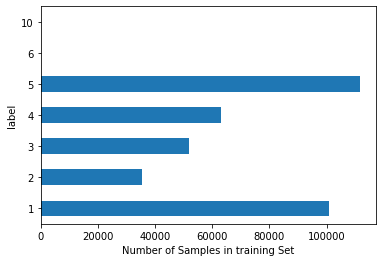

In [15]:
ax = raw_data[output_label].value_counts(sort=False).plot(kind='barh')
ax.set_xlabel('Number of Samples in training Set')
ax.set_ylabel('label')

In [16]:
df = df[(df.Satisfaction != 6) & (df.Satisfaction != 10)]

Text(0, 0.5, 'label')

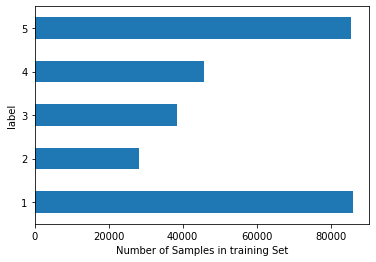

In [17]:
ax = df[output_label].value_counts(sort=False).plot(kind='barh')
ax.set_xlabel('Number of Samples in training Set')
ax.set_ylabel('label')

In [19]:
# Class count
count_1, count_2, count_3, count_4, count_5= df[output_label].value_counts()
count_min = min(count_1, count_2, count_3, count_4, count_5)

# Divide by class
df_1 = df[df[output_label] == 1]
df_2 = df[df[output_label] == 2]
df_3 = df[df[output_label] == 3]
df_4 = df[df[output_label] == 4]
df_5 = df[df[output_label] == 5]

# under sampling
df_1_under = df_1.sample(count_min)
df_2_under = df_2.sample(count_min)
df_3_under = df_3.sample(count_min)
df_4_under = df_4.sample(count_min)
df_5_under = df_5.sample(count_min)
df = df_1_under.append(df_2_under.append(df_3_under.append(df_4_under.append(df_5_under))))
df = df.sample(frac=1)

# cleaned data entries
df.shape[0]

141775

Text(0, 0.5, 'label')

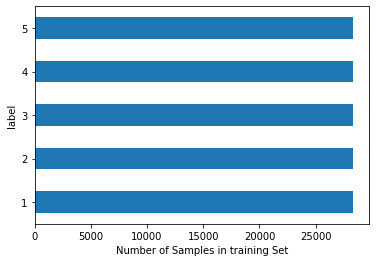

In [20]:
ax = df[output_label].value_counts(sort=False).plot(kind='barh')
ax.set_xlabel('Number of Samples in training Set')
ax.set_ylabel('label')

In [21]:
#train test split
df_train, df_test = train_test_split(df, train_size=df_split)
print("df", len(df), "\ndf_train", len(df_train), "\ndf_test", len(df_test))

df 141775 
df_train 127597 
df_test 14178


Text(0, 0.5, 'label')

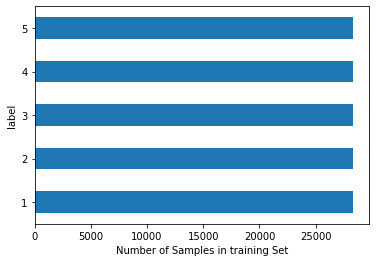

In [22]:
ax = df[output_label].value_counts(sort=False).plot(kind='barh')
ax.set_xlabel('Number of Samples in training Set')
ax.set_ylabel('label')

In [23]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens

In [24]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[], n_cpus=1)

In [25]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

In [26]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [27]:
pad_first = 0
pad_idx = transformer_tokenizer.pad_token_id

In [28]:
tokens = transformer_tokenizer.tokenize(df[input_text].iloc[0])
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)

['i', 'switched', 'te', 'og', '##est', '##rel', '28', 'after', 'having', 'extremely', 'heavy', 'periods', '.', 'i', 'tried', 'various', 'bc', '##ps', 'before', 'this', ',', 'ya', '##z', ',', 'ya', '##z', '##min', ',', 'ale', '##sse', ',', 'etc', '.', 'nothing', 'helped', '.', 'this', 'pill', 'helped', 'me', 'in', 'one', 'month', '!', 'i', 'take', '3', 'packs', 'in', 'a', 'row', ',', 'with', 'no', 'periods', ',', 'then', 'i', 'take', 'the', 'place', '##bo', 'pills', 'for', 'a', 'week', 'before', 'taking', '3', 'months', 'in', 'a', 'row', 'again', '.', 'this', 'pill', 'was', 'a', 'life', '##sa', '##ver', '-', 'i', 'was', 'very', 'an', '##emi', '##c', 'before', ',', 'and', 'this', 'has', 'helped', 'that', 'as', 'well', '.', 'unfortunately', ',', 'i', 'gained', 'about', '10', '##lb', '##s', 'with', 'this', 'pill', ',', 'but', 'overall', ',', 'it', 'it', 'worth', 'it', '.']
[1045, 7237, 8915, 13958, 4355, 16570, 2654, 2044, 2383, 5186, 3082, 6993, 1012, 1045, 2699, 2536, 4647, 4523, 2077, 2

['i',
 'switched',
 'te',
 'og',
 '##est',
 '##rel',
 '28',
 'after',
 'having',
 'extremely',
 'heavy',
 'periods',
 '.',
 'i',
 'tried',
 'various',
 'bc',
 '##ps',
 'before',
 'this',
 ',',
 'ya',
 '##z',
 ',',
 'ya',
 '##z',
 '##min',
 ',',
 'ale',
 '##sse',
 ',',
 'etc',
 '.',
 'nothing',
 'helped',
 '.',
 'this',
 'pill',
 'helped',
 'me',
 'in',
 'one',
 'month',
 '!',
 'i',
 'take',
 '3',
 'packs',
 'in',
 'a',
 'row',
 ',',
 'with',
 'no',
 'periods',
 ',',
 'then',
 'i',
 'take',
 'the',
 'place',
 '##bo',
 'pills',
 'for',
 'a',
 'week',
 'before',
 'taking',
 '3',
 'months',
 'in',
 'a',
 'row',
 'again',
 '.',
 'this',
 'pill',
 'was',
 'a',
 'life',
 '##sa',
 '##ver',
 '-',
 'i',
 'was',
 'very',
 'an',
 '##emi',
 '##c',
 'before',
 ',',
 'and',
 'this',
 'has',
 'helped',
 'that',
 'as',
 'well',
 '.',
 'unfortunately',
 ',',
 'i',
 'gained',
 'about',
 '10',
 '##lb',
 '##s',
 'with',
 'this',
 'pill',
 ',',
 'but',
 'overall',
 ',',
 'it',
 'it',
 'worth',
 'it',
 '.']

In [29]:
databunch = (TextList.from_df(df_train, cols=input_text, processor=transformer_processor)
             .split_by_rand_pct(0.1)
             .label_from_df(cols=output_label)
             .add_test(df_test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx, num_workers=0))

In [30]:
# explanation of cls, sep, pad
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
databunch.show_batch()

[CLS] token : [CLS]
[SEP] token : [SEP]
[PAD] token : [PAD]


text,target
"[CLS] il y a di ##x an ##s je me sui ##s fai ##t pre ##sc ##ri ##re 100 mg d ` ox ##y ##con ##tin ##par jo ##ur en com ##pr ##ime de 10 mg plus 80 mg de rita ##lin , comb ##ina ##ison ideal ##e . quan ##d j ` ava ##lais me ##s ox ##y ##con ##tin ##s j ` ava ##is mal au coe ##ur",5
"[CLS] i have been suffering from chronic ur ##tica ##ria , ang ##io ##de ##ma , joint pain and swelling since february 2010 . am seeing a r ##he ##uma ##to ##logist ( on top of my gp , all ##er ##gist , and soon - to - see der ##mat ##ologist ) . my r ##he ##um ##y prescribed do ##x ##ep ##in ( 30 mg ##s at night",2
"[CLS] had been on well ##bu ##tri ##n xl 300 ##mg & sr 150 ##mg for y ##rs . was feeling more depressed . dr put me on for ##fi ##vo xl 2 mt ##hs or so . all i want to do is sleep . my dreams at night are so real , my husband says i talk then say who i ' m talking to , i respond",2
"[CLS] i have been taking vitamin z for a year and a half , and it ' s been a real life save ##r . for 10 years i tried to treat my depression in natural ways ( working out , st . johns , ac ##up ##un ##cture , praying , being healthy , etc ! ) , with the haze sometimes lifting for a bit but mostly not",4
"[CLS] followed instructions from doctor before drinking this . began at 6 ##pm . the taste wasn ' t really bad for me - i love lemon . after drinking the first 16 oz . i developed a slight headache . i continued with the first round of mo ##vi ##pre ##p then drank 16 oz . of grape juice . shortly after , my vision was blur ##ry .",1


In [31]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch = databunch.one_batch()[0]
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)

[CLS] id : 101
[SEP] id : 102
[PAD] id : 0
Batch shape :  torch.Size([12, 360])
tensor([[  101,  6335,  1061,  ...,  2552, 10128,   102],
        [  101,  1045,  2031,  ...,     0,     0,     0],
        [  101,  1045,  1005,  ...,     0,     0,     0],
        ...,
        [  101,  1045,  1005,  ...,     0,     0,     0],
        [  101,  2026,  2466,  ...,     0,     0,     0],
        [  101,  2065,  2115,  ...,     0,     0,     0]])


In [32]:
# explain the work flow

# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in ``[0, 1]``:
        # ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
        
        logits = self.transformer(input_ids,
                                  attention_mask = attention_mask)[0]   
        return logits

In [33]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = num_labels
config.use_bfloat16 = use_fp16
print(config)

DistilBertConfig {
  "_num_labels": 5,
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "bad_words_ids": null,
  "bos_token_id": null,
  "decoder_start_token_id": null,
  "dim": 768,
  "do_sample": false,
  "dropout": 0.1,
  "early_stopping": false,
  "eos_token_id": null,
  "finetuning_task": null,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 512,
  "min_length": 0,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "no_repeat_ngram_size": 0,
  "num_beams": 1,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "o

In [34]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

In [35]:
CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy],
                  callback_fns=[partial(EarlyStoppingCallback), partial(CSVLogger)])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode.
if use_fp16: learner = learner.to_fp16()

In [36]:
# For DistilBERT
list_layers = [learner.model.transformer.distilbert.embeddings,
               learner.model.transformer.pre_classifier]

learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)

Learner split in 2 groups
[Sequential(
  (0): Embedding(30522, 768, padding_idx=0)
  (1): Embedding(512, 768)
  (2): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Dropout(p=0.1, inplace=False)
  (5): Linear(in_features=768, out_features=768, bias=True)
  (6): Linear(in_features=768, out_features=768, bias=True)
  (7): Linear(in_features=768, out_features=768, bias=True)
  (8): Linear(in_features=768, out_features=768, bias=True)
  (9): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (10): Dropout(p=0.1, inplace=False)
  (11): Linear(in_features=768, out_features=3072, bias=True)
  (12): Linear(in_features=3072, out_features=768, bias=True)
  (13): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (14): Dropout(p=0.1, inplace=False)
  (15): Linear(in_features=768, out_features=768, bias=True)
  (16): Linear(in_features=768, out_features=768, bias=True)
  (17): Linear(in_features=768, out_features=768, bias=True)
  (18): L

In [37]:
learner.save('untrain')

In [38]:
learner.load('untrain')
learner.freeze_to(-1)
learner.summary()

CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [360, 768]           23,440,896 False     
______________________________________________________________________
Embedding            [360, 768]           393,216    False     
______________________________________________________________________
LayerNorm            [360, 768]           1,536      False     
______________________________________________________________________
Dropout              [360, 768]           0          False     
______________________________________________________________________
Dropout              [12, 360, 360]       0          False     
______________________________________________________________________
Linear               [360, 768]           590,592    False     
______________________________________________________________________
Linear               [360, 768]           590,592    False     
_______________________________________

In [39]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.74E-01
Min loss divided by 10: 1.91E-05


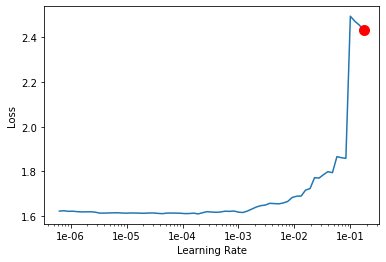

In [40]:
#explain the graph

learner.recorder.plot(suggestion=True)

In [41]:
lr = 1e-05

epoch,train_loss,valid_loss,accuracy,time
0,1.490338,1.483205,0.368916,05:21


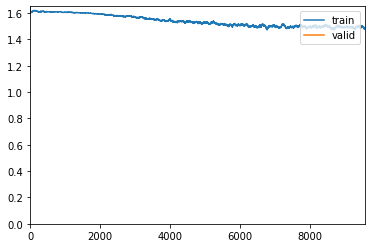

In [42]:
#explain the graph

learner.fit_one_cycle(1,max_lr=lr)

In [43]:
learner.save('first-cycle')

epoch,train_loss,valid_loss,accuracy,time
0,1.207338,1.148669,0.492358,19:43
1,1.096432,1.100335,0.517752,17:39
2,1.036475,1.065217,0.539933,19:42


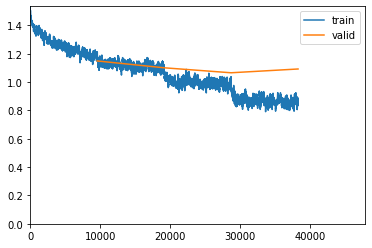

Epoch 3: early stopping


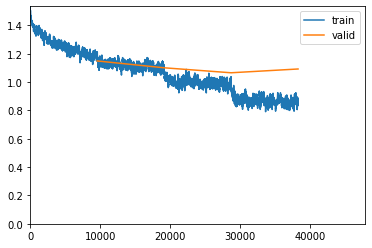

In [44]:
#explain the graph

learner.load('first-cycle')
learner.unfreeze()
learner.fit_one_cycle(5,max_lr=lr)

In [45]:
learner.export('drug_review'+'_'+input_text+str(max_length)+'_'+str(lr)+'.pkl')
export_learner = load_learner('.', 'drug_review'+'_'+input_text+str(max_length)+'_'+str(lr)+'.pkl')

In [46]:
# sample of prediction
print(export_learner.predict('This is best.'),'\n',
    export_learner.predict('This is good.'),'\n',
    export_learner.predict('This is okay.'),'\n',
    export_learner.predict('This is bad.'))

(Category 5, tensor(4), tensor([0.0279, 0.0442, 0.2059, 0.2390, 0.4830])) 
 (Category 4, tensor(3), tensor([0.0129, 0.0661, 0.3312, 0.3862, 0.2036])) 
 (Category 3, tensor(2), tensor([0.0507, 0.2175, 0.4407, 0.2097, 0.0814])) 
 (Category 1, tensor(0), tensor([0.5497, 0.2431, 0.1550, 0.0305, 0.0216]))


C:\Users\benla\anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


In [47]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

In [48]:
test_preds = get_preds_as_nparray(DatasetType.Test)

In [49]:
y_true = pd.to_numeric(df_test[output_label]) 
y_pred = np.argmax(test_preds,axis=1) +1

In [50]:
# what is f1 score
# Calculate f1 score
print(f1_score(y_true, y_pred, average='macro'))
print(f1_score(y_true, y_pred, average='micro'))
print(f1_score(y_true, y_pred, average=None))

0.47822709613114256
0.47094089434334885
[0.623638 0.443911 0.419809 0.44823  0.455547]
